In [105]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, LSTM, Concatenate, RepeatVector, Dot
from tensorflow.keras.layers import Input, Embedding, Bidirectional, Dropout
from tensorflow.keras.models import Model, Sequential

In [106]:
data = pd.read_csv('tweets.csv',  delimiter=',') #nrows = nRowsRead)

print(f"Dataset shape : {data.shape}")

Dataset shape : (14640, 15)


In [107]:
data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [108]:
print(f"Feature names : {data.columns.values}")

Feature names : ['tweet_id' 'airline_sentiment' 'airline_sentiment_confidence'
 'negativereason' 'negativereason_confidence' 'airline'
 'airline_sentiment_gold' 'name' 'negativereason_gold' 'retweet_count'
 'text' 'tweet_coord' 'tweet_created' 'tweet_location' 'user_timezone']


In [109]:
data['length'] = data['text'].apply(len)

In [110]:
data_rem = data[['airline_sentiment','text','length']]

C:\Users\mohok\AppData\Local\Temp\ipykernel_68420\155741116.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='airline_sentiment', data=data, palette='viridis')


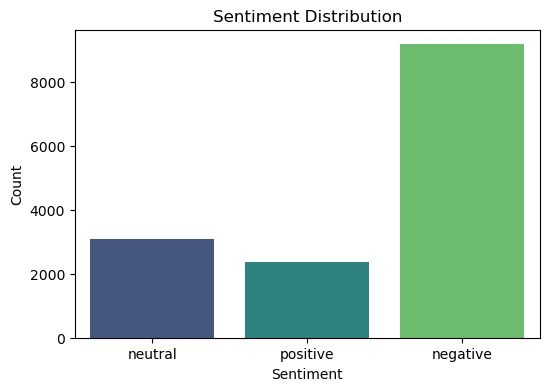

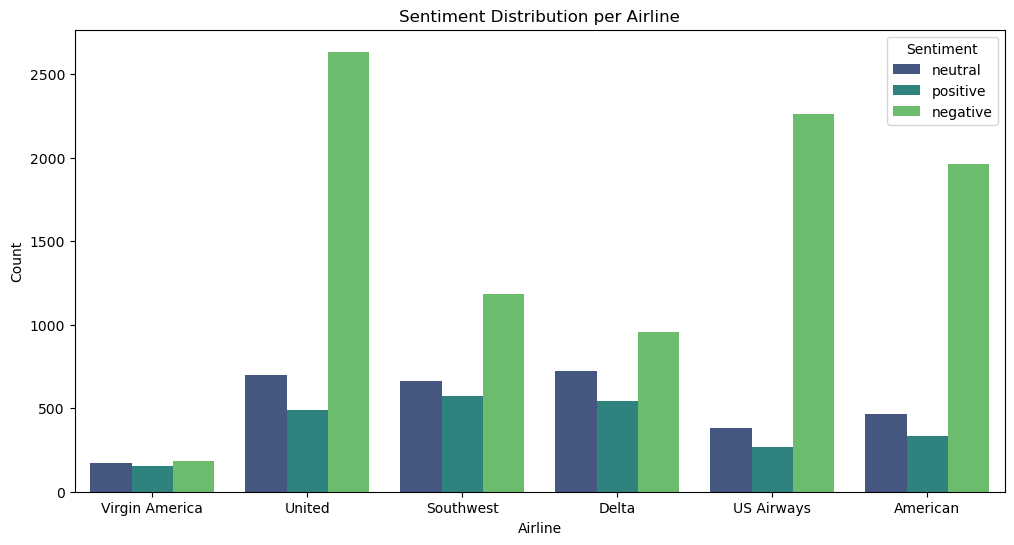

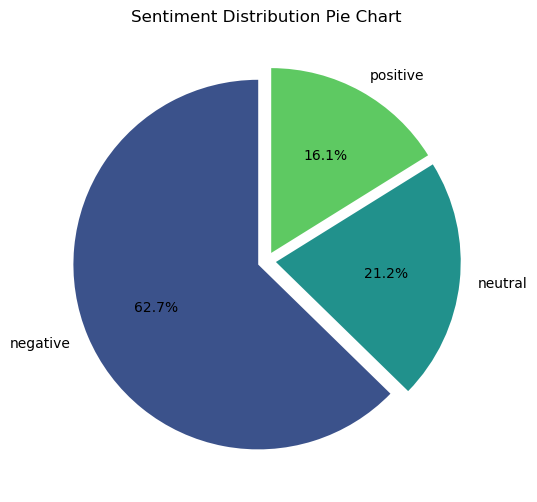

In [111]:
plt.figure(figsize=(6,4))
sns.countplot(x='airline_sentiment', data=data, palette='viridis')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(12,6))
sns.countplot(x='airline', hue='airline_sentiment', data=data, palette='viridis')
plt.title('Sentiment Distribution per Airline')
plt.xlabel('Airline')
plt.ylabel('Count')
plt.legend(title='Sentiment')
plt.show()

plt.figure(figsize=(6,6))
data['airline_sentiment'].value_counts().plot.pie(autopct='%1.1f%%', colors=sns.color_palette('viridis', 3), startangle=90, explode=[0.05]*3)
plt.title('Sentiment Distribution Pie Chart')
plt.ylabel('')  # To remove the y-label
plt.show()

In [112]:
data_rem.head()

,airline_sentiment,text,length
0,neutral,@VirginAmerica What @dhepburn said.,35
1,positive,@VirginAmerica plus you've added commercials t...,72
2,neutral,@VirginAmerica I didn't today... Must mean I n...,71
3,negative,@VirginAmerica it's really aggressive to blast...,126
4,negative,@VirginAmerica and it's a really big bad thing...,55


In [113]:
print(f"'text' column value: {data_rem.iloc[20]['text']}")
print(f"length of text : {len(data_rem.iloc[20]['text'])}")
print(f"'length' column value : {data_rem.iloc[20]['length']}")

'text' column value: @VirginAmerica why are your first fares in May over three times more than other carriers when all seats are available to select???
length of text : 130
'length' column value : 130


In [114]:
data_rem.dtypes

airline_sentiment    object
text                 object
length                int64
dtype: object

In [115]:
print(f"Rating value count: \n{data_rem['airline_sentiment'].value_counts()}")

Rating value count: 
airline_sentiment
negative    9178
neutral     3099
positive    2363
Name: count, dtype: int64


In [116]:
def preprocess_text(text):
    # Check if text is a string
    if not isinstance(text, str):
        return ""
    
    # Lowercase
    text = text.lower()
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Remove user @ references and '#' from hashtags
    text = re.sub(r'\@\w+|\#','', text)
    
    # Remove special characters, numbers, and punctuations
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\d', ' ', text)
    
    # Remove single characters
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    
    # Remove multiple spaces
    text = re.sub(r'\s+', ' ', text)
    
    return text.strip()

# Apply preprocessing
data_rem['clean_text'] = data_rem['text'].apply(preprocess_text)

# Display cleaned text
data_rem[['text', 'clean_text']].head()

C:\Users\mohok\AppData\Local\Temp\ipykernel_68420\2289141983.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_rem['clean_text'] = data_rem['text'].apply(preprocess_text)


,text,clean_text
0,@VirginAmerica What @dhepburn said.,what said
1,@VirginAmerica plus you've added commercials t...,plus you ve added commercials to the experienc...
2,@VirginAmerica I didn't today... Must mean I n...,didn today must mean need to take another trip
3,@VirginAmerica it's really aggressive to blast...,it really aggressive to blast obnoxious entert...
4,@VirginAmerica and it's a really big bad thing...,and it a really big bad thing about it


In [117]:
cv = CountVectorizer(stop_words='english')
words = cv.fit_transform(data.text)

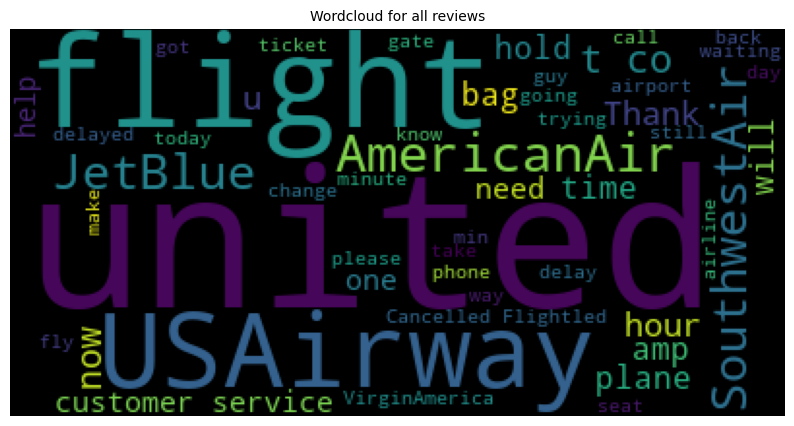

In [118]:
sentiments = " ".join([review for review in data['text']])

wc = WordCloud(background_color='black', max_words=50)

plt.figure(figsize=(10,10))
plt.imshow(wc.generate(sentiments))
plt.title('Wordcloud for all reviews', fontsize=10)
plt.axis('off')
plt.show()

In [119]:
X = data_rem['clean_text']

y = data_rem['airline_sentiment'].map({'negative':0, 'neutral':1, 'positive':2})

In [120]:
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size = 0.3, random_state = 15, stratify = y)

print(f"x_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"x_test: {X_test.shape}")
print(f"y_test: {y_test.shape}")

x_train: (10248,)
y_train: (10248,)
x_test: (4392,)
y_test: (4392,)


In [121]:
data_train, data_test = train_test_split(data_rem, test_size = 0.02)

In [122]:
data_train.text.apply(lambda x: len(x.split(" "))).mean()

17.803164424618387

In [123]:
tokenizer = Tokenizer(oov_token ="OOv")
tokenizer.fit_on_texts(X_train)
word_indexes = tokenizer.word_index
X_train_tokenized = tokenizer.texts_to_sequences(X_train)
X_test_tokenized = tokenizer.texts_to_sequences(X_test)

In [124]:
word_indexes

{'OOv': 1,
 'to': 2,
 'the': 3,
 'you': 4,
 'for': 5,
 'flight': 6,
 'on': 7,
 'and': 8,
 'my': 9,
 'is': 10,
 'in': 11,
 'it': 12,
 'of': 13,
 'me': 14,
 'that': 15,
 'your': 16,
 'have': 17,
 'was': 18,
 'can': 19,
 'not': 20,
 'no': 21,
 'with': 22,
 'at': 23,
 'this': 24,
 'get': 25,
 'we': 26,
 'but': 27,
 'be': 28,
 'from': 29,
 'cancelled': 30,
 'are': 31,
 'now': 32,
 'thanks': 33,
 'just': 34,
 'service': 35,
 'an': 36,
 'do': 37,
 'so': 38,
 'help': 39,
 'been': 40,
 'what': 41,
 'time': 42,
 'customer': 43,
 'up': 44,
 'will': 45,
 'they': 46,
 'm': 47,
 'out': 48,
 'our': 49,
 'amp': 50,
 'us': 51,
 'hours': 52,
 'hold': 53,
 'how': 54,
 'all': 55,
 'plane': 56,
 'flights': 57,
 'when': 58,
 'if': 59,
 'thank': 60,
 'there': 61,
 'still': 62,
 'why': 63,
 'one': 64,
 'need': 65,
 'please': 66,
 'would': 67,
 'am': 68,
 'delayed': 69,
 'gate': 70,
 'about': 71,
 'call': 72,
 'back': 73,
 'bag': 74,
 'flightled': 75,
 'or': 76,
 'had': 77,
 'as': 78,
 'hour': 79,
 've': 80,
 

In [125]:
vocab_size= len(word_indexes)

In [126]:
vocab_size

9318

In [127]:
padding_type = 'post'
truncating_type = 'post'
Tx = 20

In [128]:
x_train = pad_sequences(X_train_tokenized, maxlen = Tx, padding = padding_type, truncating = truncating_type)
x_test = pad_sequences(X_test_tokenized, maxlen = Tx, padding = padding_type, truncating = truncating_type)
y_train = pd.get_dummies(y_train, dtype = 'int32')
y_test = pd.get_dummies(y_test, dtype = 'int32')

In [129]:
print(f"shape of x_train: {x_train.shape}")
print(f"shape of x_test: {x_test.shape}")
print(f"shape of y_train: {y_train.shape}")
print(f"shape of y_test: {y_test.shape}")

shape of x_train: (10248, 20)
shape of x_test: (4392, 20)
shape of y_train: (10248, 3)
shape of y_test: (4392, 3)


In [130]:
n_a = 32
n_s = 64
embed_size = 128
repeator = RepeatVector(Tx)
concatenator = Concatenate(axis = -1)
densor1 = Dense(32, activation = 'relu')
dotor = Dot(axes = 1)

In [131]:
def one_step_attention(a, s_prev):
    s_prev = repeator(s_prev)
    cat = concatenator([a, s_prev])
    e = densor1(cat)
    drop_out = Dropout(.4)(e)
    alphas = tf.keras.activations.softmax(drop_out, axis = -1)
    context = dotor([alphas, a])
    
    return context

In [132]:
post_LSTM_cell = LSTM(n_s, return_state = True)
output_layer_star = Dense(3, activation = 'softmax')

In [133]:
def modelf(Tx, n_a, n_s, vacab_size, embed_size):
    sequence_input = Input(shape = (Tx, ), dtype = 'int32')
    embedded_sequences = Embedding(vocab_size+1, embed_size)(sequence_input)

    s0 = Input(shape = (n_s, ), name = 's0')
    c0 = Input(shape = (n_s, ), name = 'c0')
    s = s0
    c = c0

    a = Bidirectional(LSTM(units = n_a, return_sequences = True))(embedded_sequences)

    context = one_step_attention(a, s)
    _, s, c = post_LSTM_cell(context, initial_state = [s, c])
    out = output_layer_star(s)
    model = Model(inputs = [sequence_input, s0, c0], outputs = out)
    return model

In [134]:
model1 = modelf(Tx, n_a, n_s, vocab_size, embed_size)

In [135]:
model1.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 20)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 20, 128)   │  1,192,832 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ s0 (InputLayer)     │ (None, 64)        │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 20, 64)    │     41,216 │ embedding_1[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_1     │ (None, 20, 64)    │          0 │ s0[0][0]          │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 20, 128)   │          0 │ bidirectional_1[… │
│ (Concatenate)       │                   │            │ repeat_vector_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 20, 32)    │      4,128 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 20, 32)    │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ softmax_1 (Softmax) │ (None, 20, 32)    │          0 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_1 (Dot)         │ (None, 32, 64)    │          0 │ softmax_1[0][0],  │
│                     │                   │            │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ c0 (InputLayer)     │ (None, 64)        │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ [(None, 64),      │     33,024 │ dot_1[0][0],      │
│                     │ (None, 64),       │            │ s0[0][0],         │
│                     │ (None, 64)]       │            │ c0[0][0]          │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 3)         │        195 │ lstm_2[0][1]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,271,395 (4.85 MB)

 Trainable params: 1,271,395 (4.85 MB)

 Non-trainable params: 0 (0.00 B)

In [136]:
model1.compile(loss = 'CategoricalCrossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [137]:
s0 = np.zeros((len(x_train), n_s))
c0 = np.zeros((len(x_train), n_s))
s0_test = np.zeros((len(x_test), n_s))
c0_test = np.zeros((len(x_test), n_s))

In [138]:
BATCH_SIZE = 100
EPOCHS = 3
history = model1.fit([x_train, s0,c0],y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=([x_test, s0_test, c0_test], y_test))

Epoch 1/3
103/103 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.6407 - loss: 0.8631 - val_accuracy: 0.7402 - val_loss: 0.6199
Epoch 2/3
103/103 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.7884 - loss: 0.5098 - val_accuracy: 0.7832 - val_loss: 0.5617
Epoch 3/3
103/103 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.8846 - loss: 0.3188 - val_accuracy: 0.7782 - val_loss: 0.5729


In [139]:
y_pred = model1.predict([x_test, s0_test, c0_test])


138/138 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


In [140]:
y_pred[-4]

array([0.04643051, 0.9215151 , 0.03205439], dtype=float32)

In [141]:
y_star = np.argmax(y_pred, axis = 1)

In [142]:
sum = np.sum(y_star == y_test[1])

In [143]:
acc = sum/len(y_test)
acc

0.7135701275045537

(array([2991.,    0.,    0.,    0.,    0.,  808.,    0.,    0.,    0.,
         593.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

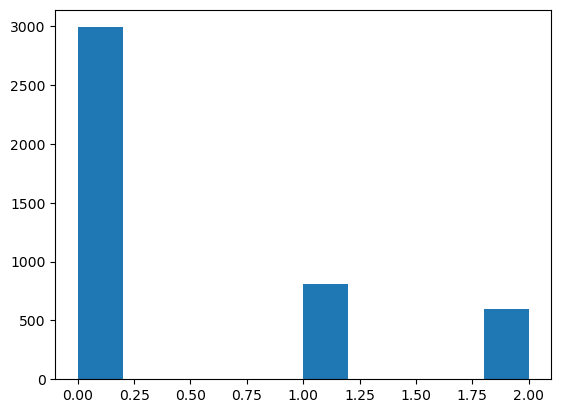

In [144]:
plt.hist(y_star)

(array([[1639.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         2753.],
        [3462.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          930.],
        [3683.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          709.]]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 3 BarContainer objects>)

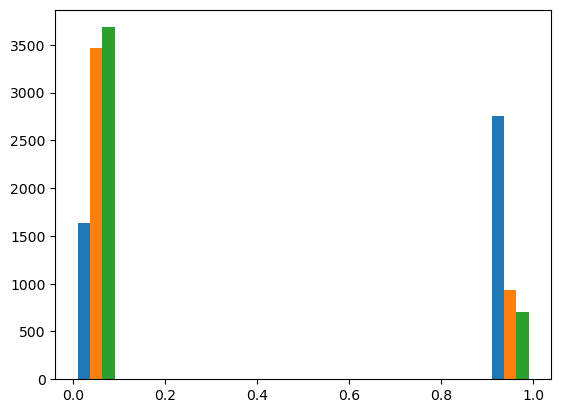

In [145]:
plt.hist(y_test)